In [2]:
# main imports
import os
import sys
import ast
import glob
import math
import shutil
import random
import importlib
import subprocess

import numpy as np
import pandas as pd

from itertools import product

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
from joypy import joyplot

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "") # directory to where definitions.py is
%aimport definitions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# paths

base_dir = "" # base directory for the analysis

orfanage_bin = "orfanage" # path to the orfanage binary
gffcompare_bin = "" # path to the gffcompare binary
gffread_bin = "" # path to the gffread binary
igvtools_bin = "" # path to the igvtools binary
sashimi_bin = "" # path to the sashimi.py binary (from the TieBrush package)

fa_fname = "hg38.fa" # path to the reference genome fasta file
gtf_fname = "refseq.gtf" # path to the reference genome gtf file
mane_gtf_fname = "MANE.v10.gtf" # path to the MANE gtf file

refseq_outdir = base_dir+"refseq/"
if not os.path.exists(refseq_outdir):
    os.makedirs(refseq_outdir)

In [6]:
# arguments
num_threads = 30

In [7]:
gtf_adjstop_fname = gtf_fname.rsplit(".",1)[0]+".adjstop.gtf"
gtf_adjstop_sorted_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".sorted.gtf"
gtf_adjstop_aa_fa_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".aa.fa"

clean_gtf_fname = gtf_adjstop_fname.rsplit(".",1)[0]+".clean.gtf"
nocds_gtf_fname = clean_gtf_fname.rsplit(".",1)[0]+".nocds.gtf"

out_gtf_fname = refseq_outdir+"orf.gtf"
out_stats_fname = refseq_outdir+"orf.stats"
out_gtf_sorted_fname = out_gtf_fname.rsplit(".",1)[0]+".sorted.gtf"

out_df_tsv_fname = refseq_outdir+"df.tsv"

In [ ]:
# standardize the annotation - adjust stop, discard anything without a start/stop codon
cmd = [gffread_bin,
       "-g",fa_fname,
       "--adj-stop","-T","-F","-J",
       "-o",gtf_adjstop_fname,
       gtf_fname]

print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",gtf_adjstop_fname,gtf_adjstop_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",gtf_adjstop_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

cmd = [gffread_bin,
       "-y",gtf_adjstop_aa_fa_fname,
       "-g",fa_fname,
       gtf_adjstop_fname]

print(" ".join(cmd))
subprocess.call(cmd)

In [7]:
# get ids to remove
# 1. seleno
# 2. polycistronic
# 3. other

# polycistronic
df = definitions.get_chains(gtf_fname,"CDS",True)
df = df[df["has_cds"]==1].reset_index(drop=True)
df["seqid"]=df["coords"].str.split(":",n=1,expand=True)[0]
df["start"] = df["chain"].apply(lambda row: row[0][0])
df["end"] = df["chain"].apply(lambda row: row[-1][1])
# add gene ids
gid=pd.read_csv(gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
gid=gid[gid["type"]=="transcript"].reset_index(drop=True)
gid["tid"]=gid["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
gid["gid"]=gid["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
gid = gid[["gid","tid"]]
print("total number of genes: "+str(len(set(gid["gid"]))))

df = df.merge(gid,on="tid",how="left",indicator=False)

print("total number of coding genes: "+str(len(set(df["gid"]))))

df["start"] = df["start"].astype(int)
df["end"] = df["end"].astype(int)

df.sort_values(by=["seqid","strand","start","end"],ascending=True,inplace=True)

df = df.groupby(by=["seqid","strand","gid"]).agg({"start":min,"end":max}).reset_index()
df.sort_values(by=["seqid","strand","start","end"],ascending=True,inplace=True)
df["nc"]=df.seqid.shift(-1)
df["nt"]=df.strand.shift(-1)
df["ns"]=df.start.shift(-1)
df["nid"]=df.gid.shift(-1)
df.fillna(0,inplace=True)
df["od"] = np.where((df["seqid"]==df["nc"]) & 
                           (df["strand"]==df["nt"]) & 
                           (df["end"]>df["ns"]),1,0)
pids = set(df[df["od"]==1]["gid"]).union(set(df[df["od"]==1]["nid"]))
print("number of poly: "+str(len(pids)))

# seleno and other exceptions

df=pd.read_csv(gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
df=df[df["type"]=="transcript"].reset_index(drop=True)
df["tid"]=df["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
df["gid"]=df["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
df["attr"]=df["attributes"].str.split("exception \"",expand=True)[1].str.split("\"",expand=True)[0]
df["seleno"] = df["attributes"].str.lower().str.contains("selen")

sids = set(df[df["seleno"]]["gid"])
print("number of seleno: "+str(len(sids)))

print("exceptions: "+", ".join(list(set(df[~(df["attr"].isna())]["attr"].tolist()))))
eids = set(df[~(df["attr"].isna())]["gid"])
print("number of exceptions: "+str(len(eids)))

total number of genes: 50531
total number of coding genes: 20442
number of poly: 550
number of seleno: 41
exceptions: rearrangement required for product, ribosomal slippage, unclassified transcription discrepancy, annotated by transcript or proteomic data, dicistronic gene, alternative start codon
number of exceptions: 846


In [8]:
dirty_gids = pids.union(sids).union(eids)
print("number of genes to discard: "+str(len(dirty_gids)))

number of genes to discard: 1423


In [9]:
# create a file without transcripts in these genes

with open(clean_gtf_fname,"w+") as outFP:
    with open(gtf_adjstop_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            gid = lcs[8].split("gene_id \"",1)[1].split("\"",1)[0]
            if not gid in dirty_gids:
                outFP.write(line)

In [10]:
# create input without CDS in it (easier to explain than "not using --keep_cds")

with open(nocds_gtf_fname,"w+") as outFP:
    with open(clean_gtf_fname,"r") as inFP:
        for line in inFP:
            lcs = line.split("\t")
            if lcs[2]=="CDS":
                continue
            
            outFP.write(line)

In [ ]:
# run orfanage on self

cmd = [orfanage_bin,
       "--reference",fa_fname,
       "--query",nocds_gtf_fname,
       "--threads",str(num_threads),
       "--output",out_gtf_fname,
       "--stats",out_stats_fname,
       "--non_aug",
       mane_gtf_fname]
print(" ".join(cmd))
subprocess.call(cmd)

igv_cmd = [igvtools_bin,"sort",out_gtf_fname,out_gtf_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)
igv_cmd = [igvtools_bin,"index",out_gtf_sorted_fname]
print(" ".join(igv_cmd))
subprocess.call(igv_cmd)

In [12]:
# let's investigate more closely and identify any eggregious examples

# we ran refseq to auto-correct itself with results in out_gtf_fname

# load chains from both and MANE and attach all together

orf_df = definitions.get_chains(out_gtf_fname,"CDS",True)
gtf_df = definitions.get_chains(clean_gtf_fname,"CDS",False)
mane_df = definitions.get_chains(mane_gtf_fname,"CDS",False)
mane_df.rename({"tid":"mane_tid"},axis=1,inplace=True)

gtf_attr = definitions.get_attribute(clean_gtf_fname,"gene_id")
gtf_attr.columns = ["tid","gid"]
mane_attr = definitions.get_attribute(mane_gtf_fname,"gene_id")
mane_attr.columns = ["tid","gid"]

In [13]:
df = orf_df.merge(gtf_df,on="tid",how="outer",indicator=True)
assert len(df[~(df["_merge"]=="both")])==0,"wrong merge"
df.drop("_merge",axis=1,inplace=True)
df.columns = ["tid","has_cds_orf","seqid","strand","coords","chain_orf","has_cds_def","chain_def"]
# now attach gene id information so we can add mane transcripts later
attr_df = gtf_attr.merge(mane_attr,on="gid",how="inner")
attr_df.columns = ["tid","gid","mane_tid"]
attr_df.drop("gid",axis=1,inplace=True)
# merge all together
df = df.merge(attr_df,on="tid",how="inner")
df = df.merge(mane_df,on="mane_tid")
df.columns = ["tid","has_cds_orf","seqid","strand","coords","chain_orf","has_cds_def","chain_def","mane_tid","has_cds_mane","chain_mane"]
df.drop("has_cds_mane",axis=1,inplace=True)

# compare chains
df[["mod_chain_orf",
         "c1len_orf",
         "c2len_orf",
         "match_start_orf",
         "match_end_orf",
         "num_bp_extra_orf",
         "num_bp_missing_orf",
         "num_bp_inframe_orf",
         "num_bp_match_orf",
         "num_bp_outframe_orf",
         "lpd_orf",
         "ilpd_orf",
         "mlpd_orf"]] = df.apply(lambda row: definitions.compare_and_extract(row["chain_orf"],row["chain_mane"],row["strand"]),axis=1)

df[["mod_chain_def",
         "c1len_def",
         "c2len_def",
         "match_start_def",
         "match_end_def",
         "num_bp_extra_def",
         "num_bp_missing_def",
         "num_bp_inframe_def",
         "num_bp_match_def",
         "num_bp_outframe_def",
         "lpd_def",
         "ilpd_def",
         "mlpd_def"]] = df.apply(lambda row: definitions.compare_and_extract(row["chain_def"],row["chain_mane"],row["strand"]),axis=1)

# save
df.to_csv(out_df_tsv_fname,sep="\t",index=False)

df.head()

,tid,has_cds_orf,seqid,strand,coords,chain_orf,has_cds_def,chain_def,mane_tid,chain_mane,mod_chain_orf,c1len_orf,c2len_orf,match_start_orf,match_end_orf,num_bp_extra_orf,num_bp_missing_orf,num_bp_inframe_orf,num_bp_match_orf,num_bp_outframe_orf,lpd_orf,ilpd_orf,mlpd_orf,mod_chain_def,c1len_def,c2len_def,match_start_def,match_end_def,num_bp_extra_def,num_bp_missing_def,num_bp_inframe_def,num_bp_match_def,num_bp_outframe_def,lpd_def,ilpd_def,mlpd_def
0,rna-XM_005244720.5,1,chr1,+,chr1:1308597-1310853,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,13,238,473,674,201,75,51,73,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,13,238,473,674,201,75,51,73
1,rna-XM_047444716.1,1,chr1,+,chr1:1308597-1311016,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",729,912,True,False,17,200,699,712,13,79,76,78,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",729,912,True,False,17,200,699,712,13,79,76,78
2,rna-XM_047444722.1,1,chr1,+,chr1:1308597-1311071,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,0,225,473,687,214,75,51,75,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,0,225,473,687,214,75,51,75
3,rna-NM_001346116.2,1,chr1,+,chr1:1308597-1311677,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",981,912,True,True,69,0,912,912,0,107,100,100,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",981,912,True,True,69,0,912,912,0,107,100,100
4,rna-NM_153339.3,1,chr1,+,chr1:1308597-1311677,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",912,912,True,True,0,0,912,912,0,100,100,100,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",912,912,True,True,0,0,912,912,0,100,100,100


In [8]:
# now let's get down to business

df = pd.read_csv(refseq_outdir+"df.tsv",sep="\t")

print("total number of transcripts "+str(len(df)))

print("number of transcripts with ORF in RefSeq: "+str(len(df[df["has_cds_def"]==1])))
print("number of transcripts without ORF in RefSeq: "+str(len(df[df["has_cds_def"]==0])))

print("number of transcripts with ORF in ORFanage: "+str(len(df[df["has_cds_orf"]==1])))
print("number of transcripts without ORF in ORFanage: "+str(len(df[df["has_cds_orf"]==0])))

print("number of transcripts RefSeq==MANE: "+str(len(df[df["chain_def"]==df["chain_mane"]])))
print("number of transcripts RefSeq!=MANE: "+str(len(df[~(df["chain_def"]==df["chain_mane"])&(df["has_cds_def"]==1)])))

print("number of transcripts ORFanage==MANE: "+str(len(df[df["chain_orf"]==df["chain_mane"]])))
print("number of transcripts ORFanage!=MANE: "+str(len(df[~(df["chain_orf"]==df["chain_mane"])&(df["has_cds_orf"]==1)])))

print("number of transcripts missing ORF in both: "+str(len(df[(df["has_cds_orf"]==0)&(df["has_cds_def"]==0)])))

print("number of transcripts RefSeq==ORFanage==MANE: "+str(len(df[(df["chain_orf"]==df["chain_mane"])&
                                                                  (df["chain_def"]==df["chain_mane"])])))

print("number of transcripts RefSeq!=(ORFanage==MANE): "+str(len(df[(df["chain_orf"]==df["chain_mane"])&
                                                                    ~(df["chain_def"]==df["chain_mane"])&
                                                                    (df["has_cds_def"]==1)])))

print("number of transcripts No ORF RefSeq AND (ORFanage==MANE): "+str(len(df[(df["chain_orf"]==df["chain_mane"])&
                                                                    ~(df["chain_def"]==df["chain_mane"])&
                                                                    (df["has_cds_def"]==0)])))

print("number of transcripts No ORF RefSeq AND (ORFanage!=MANE): "+str(len(df[~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["has_cds_orf"]==1)&
                                                                    (df["has_cds_def"]==0)])))


print("number of transcripts ORFanage!=(RefSeq==MANE): "+str(len(df[(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["has_cds_orf"]==1)])))

print("number of transcripts No ORF ORFanage AND (RefSeq==MANE): "+str(len(df[(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["has_cds_orf"]==0)])))


print("number of transcripts ORFanage != RefSeq= != MANE: "+str(len(df[~(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["has_cds_def"]==1)&
                                                                    (df["has_cds_orf"]==1)])))

print("Of those number of transcripts (ORFanage == RefSeq) != MANE: "+str(len(df[~(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    (df["chain_orf"]==df["chain_def"])&
                                                                    (df["has_cds_def"]==1)&
                                                                    (df["has_cds_orf"]==1)])))

print("Of those number of transcripts (ORFanage != RefSeq) != MANE: "+str(len(df[~(df["chain_def"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_mane"])&
                                                                    ~(df["chain_orf"]==df["chain_def"])&
                                                                    (df["has_cds_def"]==1)&
                                                                    (df["has_cds_orf"]==1)])))

print("number of transcripts No ORFanage AND (RefSeq= != MANE): "+str(len(df[~(df["chain_def"]==df["chain_mane"])&
                                                                    (df["has_cds_def"]==1)&
                                                                    (df["has_cds_orf"]==0)])))

total number of transcripts 135694
number of transcripts with ORF in RefSeq: 124798
number of transcripts without ORF in RefSeq: 10896
number of transcripts with ORF in ORFanage: 135149
number of transcripts without ORF in ORFanage: 545
number of transcripts RefSeq==MANE: 37033
number of transcripts RefSeq!=MANE: 87765
number of transcripts ORFanage==MANE: 40428
number of transcripts ORFanage!=MANE: 94721
number of transcripts missing ORF in both: 462
number of transcripts RefSeq==ORFanage==MANE: 37022
number of transcripts RefSeq!=(ORFanage==MANE): 2212
number of transcripts No ORF RefSeq AND (ORFanage==MANE): 1194
number of transcripts No ORF RefSeq AND (ORFanage!=MANE): 9240
number of transcripts ORFanage!=(RefSeq==MANE): 11
number of transcripts No ORF ORFanage AND (RefSeq==MANE): 0
number of transcripts ORFanage != RefSeq= != MANE: 85470
Of those number of transcripts (ORFanage == RefSeq) != MANE: 80180
Of those number of transcripts (ORFanage != RefSeq) != MANE: 5290
number of tr

,tid,has_cds_orf,seqid,strand,coords,chain_orf,has_cds_def,chain_def,mane_tid,chain_mane,mod_chain_orf,c1len_orf,c2len_orf,match_start_orf,match_end_orf,num_bp_extra_orf,num_bp_missing_orf,num_bp_inframe_orf,num_bp_match_orf,num_bp_outframe_orf,lpd_orf,ilpd_orf,mlpd_orf,mod_chain_def,c1len_def,c2len_def,match_start_def,match_end_def,num_bp_extra_def,num_bp_missing_def,num_bp_inframe_def,num_bp_match_def,num_bp_outframe_def,lpd_def,ilpd_def,mlpd_def
0,rna-XR_007067984.1,1,chr22,-,chr22:26450882-26483783,"[[26453233, 26453404], [26457859, 26457967], [...",0,[],rna-NM_022081.6,"[[26453233, 26453404], [26457859, 26457967], [...","[[26481722, 26481762, 0], [26479265, 26479355,...",2181,2127,True,True,54,0,2127,2127,0,102,100,100,"[[26453233, 26453404, 1], [26457859, 26457967,...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,rna-XR_007066666.1,1,chr19,+,chr19:21142040-21192182,"[[21142184, 21142186], [21143551, 21143643], [...",0,[],rna-NM_133473.4,"[[21142184, 21142186], [21143551, 21143643], [...","[[21142184, 21142186, 0], [21143551, 21143643,...",1782,1731,True,True,51,0,1731,1731,0,102,100,100,"[[21142184, 21142186, 1], [21143551, 21143643,...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,rna-XR_007093273.1,1,chr3,+,chr3:111542197-111665996,"[[111542249, 111542309], [111545046, 111545402...",0,[],rna-NM_005816.5,"[[111542249, 111542309], [111545046, 111545402...","[[111542249, 111542309, 0], [111545046, 111545...",1758,1710,True,True,48,0,1710,1710,0,102,100,100,"[[111542249, 111542309, 1], [111545046, 111545...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,rna-XR_950796.1,1,chr16,+,chr16:31259975-31332869,"[[31260065, 31260092], [31261692, 31261797], [...",0,[],rna-NM_000632.4,"[[31260065, 31260092], [31261692, 31261797], [...","[[31260065, 31260092, 0], [31261692, 31261797,...",3462,3459,True,True,3,0,3459,3459,0,100,100,100,"[[31260065, 31260092, 1], [31261692, 31261797,...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,rna-XR_007095652.1,1,chr3,-,chr3:15667236-15797979,"[[15670270, 15670556], [15675898, 15675989], [...",0,[],rna-NM_001349278.2,"[[15670270, 15670556], [15675898, 15675989], [...","[[15796405, 15796521, 0], [15796396, 15796404,...",3261,3252,True,True,9,0,3252,3252,0,100,100,100,"[[15670270, 15670556, 1], [15675898, 15675989,...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,rna-NR_158896.1,1,chr6,+,chr6:143060463-143341058,"[[143060645, 143060653], [143060947, 143061066...",0,[],rna-NM_016108.4,"[[143060926, 143061066], [143136835, 143136990...","[[143060645, 143060653, -1], [143060926, 14306...",693,717,False,False,35,59,658,658,0,96,91,91,"[[143060926, 143061066, 1], [143136835, 143136...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
959,rna-XR_007066502.1,1,chr1,+,chr1:32013868-32060850,"[[32013996, 32014377], [32030298, 32030422], [...",0,[],rna-NM_006559.3,"[[32013996, 32014377], [32030298, 32030422], [...","[[32013996, 32014377, 0], [32030298, 32030422,...",1215,1332,True,True,0,117,1215,1215,0,91,91,91,"[[32013996, 32014377, 1], [32030298, 32030422,...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
960,rna-NR_047676.2,1,chr5,+,chr5:33440965-33468086,"[[33448580, 33448731], [33453289, 33453412], [...",0,[],rna-NM_152295.5,"[[33441087, 33441143], [33445324, 33445404], [...","[[33441087, 33441143, 1], [33445324, 33445404,...",1995,2172,False,True,0,177,1995,1995,0,91,91,91,"[[33441087, 33441143, 1], [33445324, 33445404,...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
961,rna-XR_007065547.1,1,chr17,+,chr17:78378649-78424659,"[[78379184, 78379239], [78392476, 78392665], [...",0,[],rna-NM_024419.5,"[[78378666, 78378808], [78392476, 78392665], [...","[[78378666, 78378808, 1], [78379184, 78379239,...",1584,1671,False,True,56,143,1528,1528,0,94,91,91,"[[78378666, 78378808, 1], [78392476, 78392665,...",-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


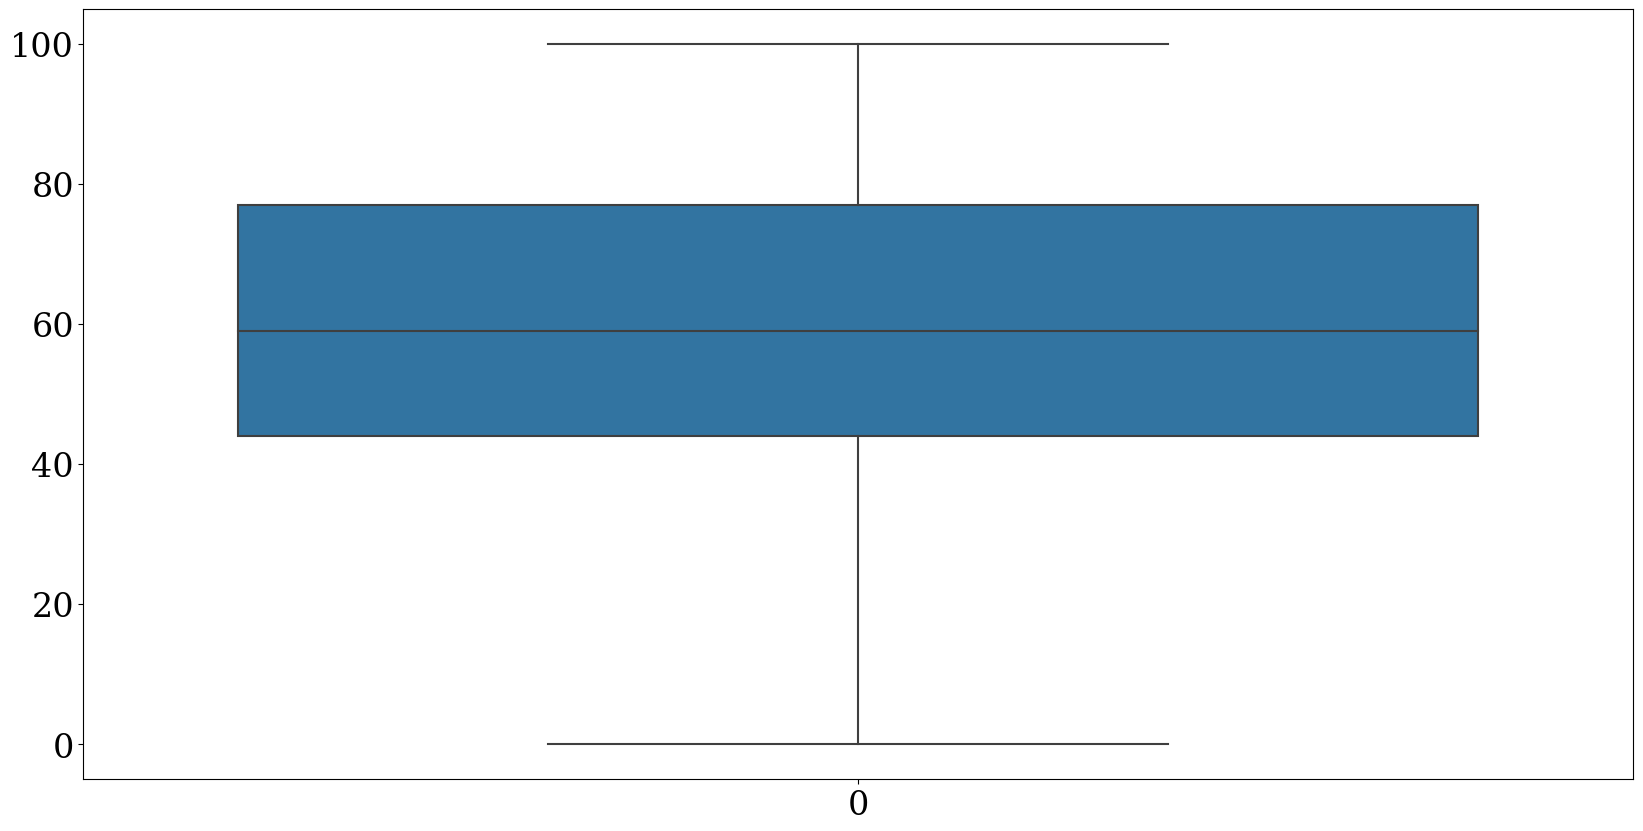

In [19]:
orfNEmaneNOdef = df[~(df["chain_orf"]==df["chain_mane"])&
                    (df["has_cds_orf"]==1)&
                    (df["has_cds_def"]==0)].reset_index(drop=True)
sns.boxplot(orfNEmaneNOdef["ilpd_orf"])
orfNEmaneNOdef = orfNEmaneNOdef.sort_values(by="ilpd_orf",ascending=False)
orfNEmaneNOdef[orfNEmaneNOdef["ilpd_orf"]>90].reset_index(drop=True)

In [ ]:
# make figures for the top cases to see if we can find smth good
if not os.path.exists(refseq_outdir+"orfNEmaneNOdef/"):
    os.makedirs(refseq_outdir+"orfNEmaneNOdef/")
    
for idx,row in orfNEmaneNOdef[orfNEmaneNOdef["ilpd_orf"]>90].iterrows():
    qtid = row["tid"]
    mane_tid = row["mane_tid"]
    
    cur_base_fname = refseq_outdir+"orfNEmaneNOdef/"+str(idx)+"_"+qtid
    definitions.extract_sashimi(sashimi_bin,mane_gtf_fname,clean_gtf_fname,refseq_outdir+"orf.gtf",cur_base_fname,mane_tid,qtid,qtid+" "+mane_tid+" "+str(row["ilpd_orf"]))

In [21]:
# isolate cases where all are different from one another
orfNEmaneNEdef = df[~(df["chain_def"]==df["chain_mane"])&
                    ~(df["chain_orf"]==df["chain_mane"])&
                    ~(df["chain_orf"]==df["chain_def"])&
                    (df["has_cds_def"]==1)&
                    (df["has_cds_orf"]==1)].reset_index(drop=True)

In [22]:
# identify cases where transcript starts at non-zero phase

phased_chains = definitions.get_chains(clean_gtf_fname,"CDS",True,True)
phased_chains = phased_chains[phased_chains["has_cds"]==1].reset_index(drop=True)
def get_start_phase(chain,strand):
    sc = sorted(chain)
    if strand=="+":
        return sc[0][-1]
    else:
        return sc[-1][-1]
phased_chains["start_phase"] = phased_chains.apply(lambda row: get_start_phase(row["chain"],row["strand"]),axis=1)

misphased_tids = set(phased_chains[~(phased_chains["start_phase"]=="0")]["tid"].tolist())
misphased = orfNEmaneNEdef[orfNEmaneNEdef["tid"].isin(misphased_tids)].reset_index(drop=True)
orfNEmaneNEdef = orfNEmaneNEdef[~(orfNEmaneNEdef["tid"].isin(misphased["tid"]))].reset_index(drop=True)
print("number of transcripts with RefSeq start phase!=0: "+str(len(misphased)))

number of transcripts with RefSeq start phase!=0: 0


In [23]:
# plot ilpd and get some good examples

orfNEmaneNEdef["chain_orf"] = orfNEmaneNEdef["chain_orf"].apply(lambda chainstr: ast.literal_eval(chainstr))
orfNEmaneNEdef["chain_def"] = orfNEmaneNEdef["chain_def"].apply(lambda chainstr: ast.literal_eval(chainstr))
orfNEmaneNEdef["chain_mane"] = orfNEmaneNEdef["chain_mane"].apply(lambda chainstr: ast.literal_eval(chainstr))

orfNEmaneNEdef.drop(["mod_chain_orf",
              "c1len_orf",
              "c2len_orf",
              "num_bp_match_orf",
              "lpd_orf",
              "mlpd_orf"],axis=1,inplace=True)

orfNEmaneNEdef.drop(["mod_chain_def",
              "c1len_def",
              "c2len_def",
              "num_bp_match_def",
              "lpd_def",
              "mlpd_def"],axis=1,inplace=True)

orfNEmaneNEdef["ilpd_change"] = orfNEmaneNEdef["ilpd_orf"]-orfNEmaneNEdef["ilpd_def"]
print("number of transcripts with decreased ilpd: "+str(len(orfNEmaneNEdef[orfNEmaneNEdef["ilpd_change"]<0])))
print("number of transcripts with increased ilpd: "+str(len(orfNEmaneNEdef[orfNEmaneNEdef["ilpd_change"]>0])))
print("number of transcripts with unchanged ilpd: "+str(len(orfNEmaneNEdef[orfNEmaneNEdef["ilpd_change"]==0])))

# reasons for lower ilpd
# 1. seleno
# 2. polycistronic
# 3. alternative start/end

orfNEmaneNEdef.sort_values(by="ilpd_change",inplace=True,ascending=False)
orfNEmaneNEdef.to_csv(refseq_outdir+"orfNEmaneNEdef.tsv",index=False,sep="\t")
orfNEmaneNEdef.head()

number of transcripts with decreased ilpd: 29
number of transcripts with increased ilpd: 613
number of transcripts with unchanged ilpd: 4648


,tid,has_cds_orf,seqid,strand,coords,chain_orf,has_cds_def,chain_def,mane_tid,chain_mane,match_start_orf,match_end_orf,num_bp_extra_orf,num_bp_missing_orf,num_bp_inframe_orf,num_bp_outframe_orf,ilpd_orf,match_start_def,match_end_def,num_bp_extra_def,num_bp_missing_def,num_bp_inframe_def,num_bp_outframe_def,ilpd_def,ilpd_change
4385,rna-NM_001256281.3,1,chr17,-,chr17:28714284-28717868,"[[28714643, 28714710], [28714793, 28714900], [...",1,"[[28716053, 28716061], [28716903, 28716994], [...",rna-NM_031934.6,"[[28714643, 28714710], [28714793, 28714900], [...",True,True,3,0,780,0,100,False,False,445,628,0,152,0,100
426,rna-NM_001282672.2,1,chr1,-,chr1:2184477-2194772,"[[2187158, 2187206], [2189713, 2189781], [2193...",1,"[[2185278, 2185513], [2186004, 2186211]]",rna-NM_182533.4,"[[2189709, 2189781], [2193639, 2193910], [2193...",True,False,49,4,539,0,99,False,False,444,543,0,0,0,99
2207,rna-NM_001351028.2,1,chr7,-,chr7:149881360-150323545,"[[149909673, 149909705], [150284753, 150284845...",1,"[[149888961, 149889005], [149891191, 149891301...",rna-NM_001164458.2,"[[150248986, 150249054], [150284753, 150284845...",True,False,33,69,564,0,89,False,False,337,610,0,23,0,89
4888,rna-NM_001077490.3,1,chr20,+,chr20:58852716-58911192,"[[58854346, 58855333], [58895612, 58895684], [...",1,"[[58853453, 58855333]]",rna-NM_000516.7,"[[58891727, 58891865], [58895612, 58895684], [...",False,True,988,139,1046,0,88,False,False,1881,1185,0,0,0,88
4886,rna-NM_016592.5,1,chr20,+,chr20:58839748-58911192,"[[58840844, 58840886], [58895612, 58895684], [...",1,"[[58840107, 58840844]]",rna-NM_000516.7,"[[58891727, 58891865], [58895612, 58895684], [...",False,True,46,139,1046,0,88,False,False,738,1185,0,0,0,88


In [ ]:
# make figures for the top cases to see if we can find smth good
if not os.path.exists(refseq_outdir+"orfNEmaneNEdef/"):
    os.makedirs(refseq_outdir+"orfNEmaneNEdef/")
    
for idx,row in orfNEmaneNEdef.iterrows():
    qtid = row["tid"]
    mane_tid = row["mane_tid"]
    
    cur_base_fname = refseq_outdir+"orfNEmaneNEdef/"+str(idx)+"_"+qtid
    definitions.extract_sashimi(sashimi_bin,mane_gtf_fname,clean_gtf_fname,refseq_outdir+"orf.gtf",cur_base_fname,mane_tid,qtid,qtid+" "+mane_tid+" "+str(row["ilpd_change"]))

In [ ]:
# how well does it work if we randomly pick one cds for each gene and use that to re-annotate?

# this can be run several times to get the distribution

df=pd.read_csv(clean_gtf_fname,sep="\t",names=definitions.gff3cols,comment="#")
cdf=df[df["type"]=="CDS"].reset_index(drop=True)
cdf["tid"]=cdf["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
cdf["gid"]=cdf["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]

rdf = cdf[~cdf["gid"].isnull()][["tid",
                               "gid"]].drop_duplicates(keep="first").groupby(by="gid").agg({"tid":["count",
                                                                                                         lambda grp: set(grp)]}).reset_index()
rdf.columns = ["gid","count","list"]

print("total number of genes with CDS in them: "+str(len(rdf)))
print("total number of transcript with CDS: "+str(rdf["count"].sum()))
print("number of genes with multiple coding isoforms: "+str(len(rdf[rdf["count"]>1])))
print("number of transcripts in genes with multiple coding isoforms: "+str(rdf[rdf["count"]>1]["count"].sum()))

mrdf = rdf[rdf["count"]>1].reset_index(drop=True)

sns.boxplot(rdf["count"])

In [ ]:
num_rands = 10
percs = [0,0.25,0.50,0.75]
out_gtf_fname = refseq_outdir+"orf.gtf"

ref_gids = set(mrdf["gid"])

for p in percs:
    for i in range(num_rands):
        # for each gene get 1 random CDS and everything else
        ref_tids = set()
        q_tids = set()
        for idx,row in mrdf.iterrows():
            nrs = int(max(1,float(len(list(row["list"])))*p))
            rs = random.sample(list(row["list"]),nrs)
            for r in rs:
                ref_tids.add(r)
            for v in row["list"]:
                if v in rs:
                    continue
                else:
                    q_tids.add(v)

        rand_gtf_fname = out_gtf_fname.rsplit(".",1)[0]+".rand_"+str(int(p*100))+"."+str(i)+".gtf"

        with open(rand_gtf_fname,"w+") as outFP:
            with open(clean_gtf_fname,"r") as inFP:
                for line in inFP:
                    lcs = line.split("\t")
                    if not len(lcs) == 9:
                        continue

                    tid = lcs[8].split("transcript_id \"", 1)[1].split("\"", 1)[0]
                    if tid in ref_tids:
                        outFP.write(line)
                    else:
                        if tid in q_tids:
                            if not lcs[2]=="CDS":
                                outFP.write(line)

        rand_orf_gtf_fname = rand_gtf_fname.rsplit(".",1)[0]+".orf.gtf"

        cmd = [orfanage_bin,
               "--reference",fa_fname,
               "--query",rand_gtf_fname,
               "--threads",str(num_threads),
               "--output",rand_orf_gtf_fname,
               "--non_aug",
               "--keep_cds",
               rand_gtf_fname]
        print(" ".join(cmd))
        subprocess.call(cmd)

In [30]:
# load reference chains
ref_df = definitions.get_chains(clean_gtf_fname,"CDS",True)

res = dict()
res_ilpd = pd.DataFrame()

for p in percs:
    for i in range(num_rands):
        rand_gtf_fname = out_gtf_fname.rsplit(".",1)[0]+".rand_"+str(int(p*100))+"."+str(i)+".gtf"
        rand_orf_gtf_fname = rand_gtf_fname.rsplit(".",1)[0]+".orf.gtf"

        # load orf and compare to red
        q_df = definitions.get_chains(rand_orf_gtf_fname,"CDS",False)
        q_adf = definitions.get_attribute(rand_orf_gtf_fname,"orfanage_template")
        q_df = q_df.merge(q_adf,on="tid",how='left')
        comp_df = q_df.merge(ref_df,on="tid",how="left")
        comp_df.columns = ["tid","orf_has_cds","orf_chain","orf_templ","ref_has_cds","seqid","strand","coords","ref_chain"]
        comp_df[["mod_chain",
                "c1len",
                "c2len",
                "match_start",
                "match_end",
                "num_bp_extra",
                "num_bp_missing",
                "num_bp_inframe",
                "num_bp_match",
                "num_bp_outframe",
                "lpd",
                "ilpd",
                "mlpd"]] = comp_df.apply(lambda row: definitions.compare_and_extract(row["orf_chain"],row["ref_chain"],row["strand"]),axis=1)
        comp_df.drop(["match_start","match_end","num_bp_match","lpd","mlpd"],axis=1,inplace=True)
        
        ilpd_df = comp_df[["ilpd"]].reset_index(drop=True)
        ilpd_df["perc"] = p
        ilpd_df["iter"] = i
        res_ilpd = pd.concat([res_ilpd,ilpd_df],axis=0)

        # get some numbers
        nmt = len(comp_df[(comp_df["ref_has_cds"]==1)&(comp_df["orf_has_cds"]==0)]) # number of missing CDS
        nmr = len(comp_df[comp_df["ref_chain"]==comp_df["orf_chain"]]) # number with matching chains
        nnr = len(comp_df[~(comp_df["ref_chain"]==comp_df["orf_chain"])]) # number with mis-matching chains
        mean_ilpd = comp_df["ilpd"].mean()

        res[str(i)+"."+str(p)] = [i,p,nmt,nmr,nnr,mean_ilpd]
        
res_ilpd.to_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t",index=False)

res = pd.DataFrame.from_dict(res,orient="index").reset_index()
res.columns = ["idx","iter","perc","missing","matching","mismatching","mean_ilpd"]
res.drop("idx",axis=1,inplace=True)
res.to_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t",index=False)

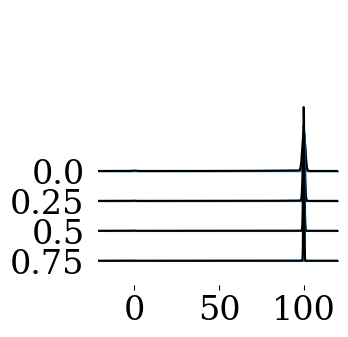

In [32]:
res_ilpd = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.ilpd.tsv",sep="\t")
res = pd.read_csv(out_gtf_fname.rsplit(".",1)[0]+".rand.tsv",sep="\t")

fig,axes = joyplot(res_ilpd[["perc","ilpd"]],by='perc',column='ilpd',figsize=(4,4))
plt.show()